### This is an Exercise on the Linear Regression With Time series

In [1]:
# Setup notebook
from pathlib import Path
from warnings import simplefilter
from statsmodels.tsa.deterministic import DeterministicProcess

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates


data_dir = Path('./data/')
comp_dir = Path('./data/store-sales-time-series-forecasting/')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

One advantage linear regression has over more complicated algorithms is that the models it creates are explainable -- it's easy to interpret what contribution each feature makes to the predictions. In the model target = weight * feature + bias, the weight tells you by how much the target changes on average for each unit of change in the feature.

The next cell to give a linear regression on Hardcover Sales.

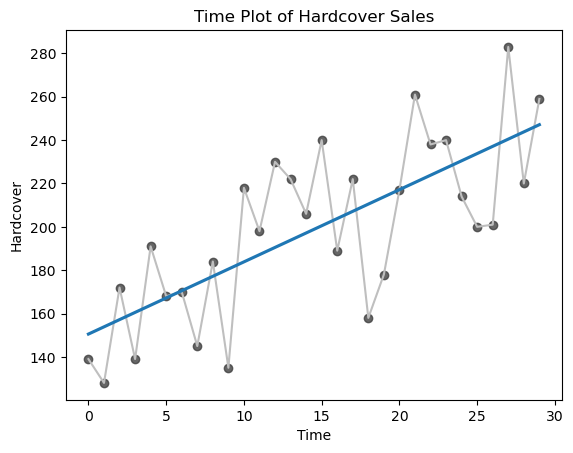

In [2]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Consider the model `target = weight * lag_1 + error`, where error is random noise and weight is a number between -1 and 1. The weight in this case tells you how likely the next time step will have the same sign as the previous time step: a weight close to 1 means target will likely have the same sign as the previous step, while a weight close to -1 means target will likely have the opposite sign.

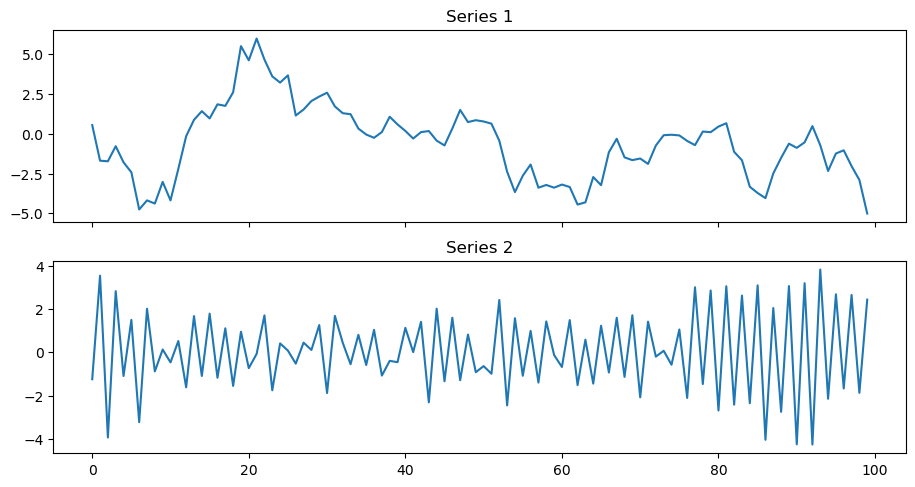

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

In [4]:
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

In [5]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

time = np.arange(len(df.index)) # time dummy

df['time'] = time 

# Create training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

# Regression line
intercept = model.intercept_
coef = model.coef_

print(model.score(X, y), model.intercept_, model.coef_)
line = coef * X + intercept

0.5161529764383439 194.23279019701053 [0.19434695]


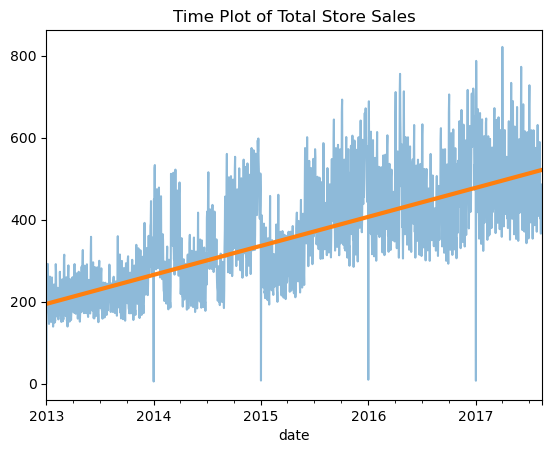

In [6]:
# Visualization 
ax = y.plot(alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [7]:
df

,sales,time
date,,
2013-01-01,1.409438,0
2013-01-02,278.390808,1
2013-01-03,202.840195,2
2013-01-04,198.911148,3
2013-01-05,267.873230,4
...,...,...
2017-08-11,463.733856,1679
2017-08-12,444.798279,1680
2017-08-13,485.768616,1681


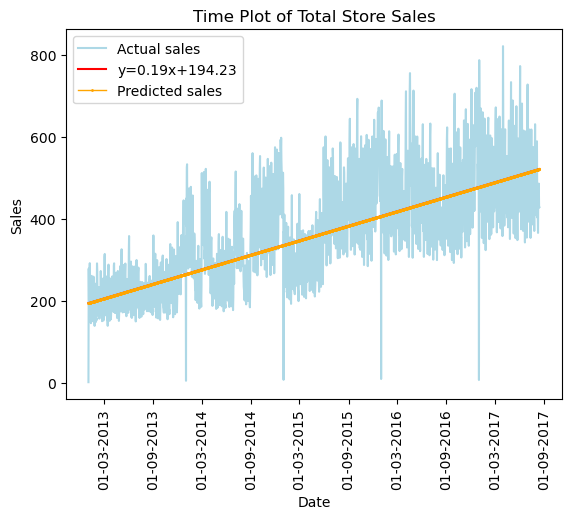

In [8]:
# This blocks constructs a figure with data series `plot_date`

fig, ax = plt.subplots()
ax.plot_date(X.index, y, 'lightblue', label = 'Actual sales')
plt.plot_date(X.index, line, 'r', label='y={:.2f}x+{:.2f}'.format(float(coef), intercept)) # This is a line created from Linear Regression Equation
ax.plot_date(X.index, y_pred, color='orange', linewidth=1, label = 'Predicted sales', linestyle='-', markersize=1)
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation=90)
ax.set_title('Time Plot of Total Store Sales')
plt.legend();

## Trends 
### Moving Average Plots
To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

Let's create a trend for the Tunnel Traffic dataset

In [33]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("./data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

In [10]:
tunnel

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569
...,...
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165


Let's make a moving average plot to see what kind of trend this series has. Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, first use the `rolling` method to begin a windowed computation. Follow this by the `mean` method to compute the average over the window. As we can see, the trend of Tunnel Traffic appears to be about linear.

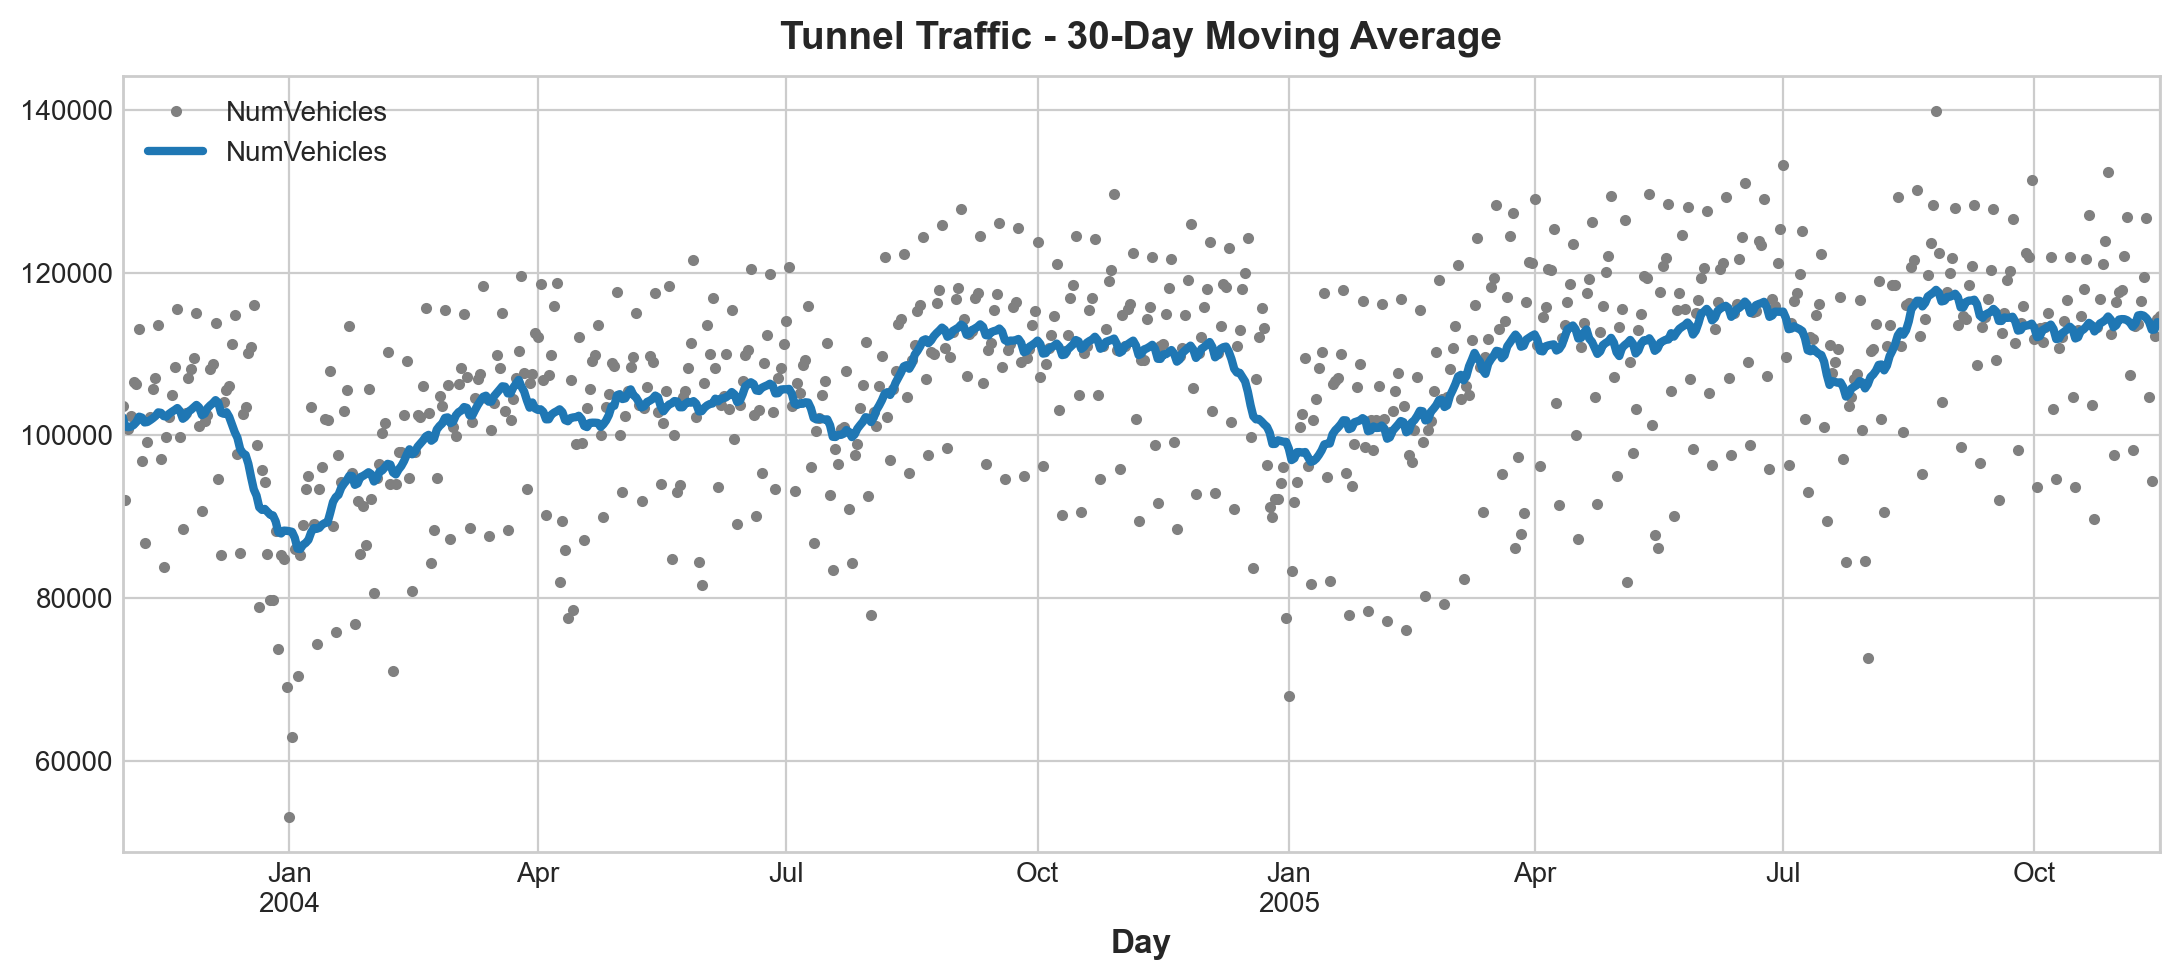

In [62]:
moving_average = tunnel.rolling(
    window=30,       # 30-day window
    center=True,      # puts the average at the center of the window
    min_periods=10,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5", label = 'Number of Cars')
moving_average.plot(
     ax=ax, linewidth=3, title="Tunnel Traffic - 30-Day Moving Average", label='Average',
);

Earlier we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the statsmodels library called `DeterministicProcess`. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [15]:
dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument

X = dp.in_sample()

X

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0
...,...,...
2005-11-12,1.0,743.0
2005-11-13,1.0,744.0
2005-11-14,1.0,745.0


(A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.)

We create our trend model basically as before, though note the addition of the `fit_intercept=False` argument.

In [18]:
y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Freq: D, Length: 747, dtype: float64

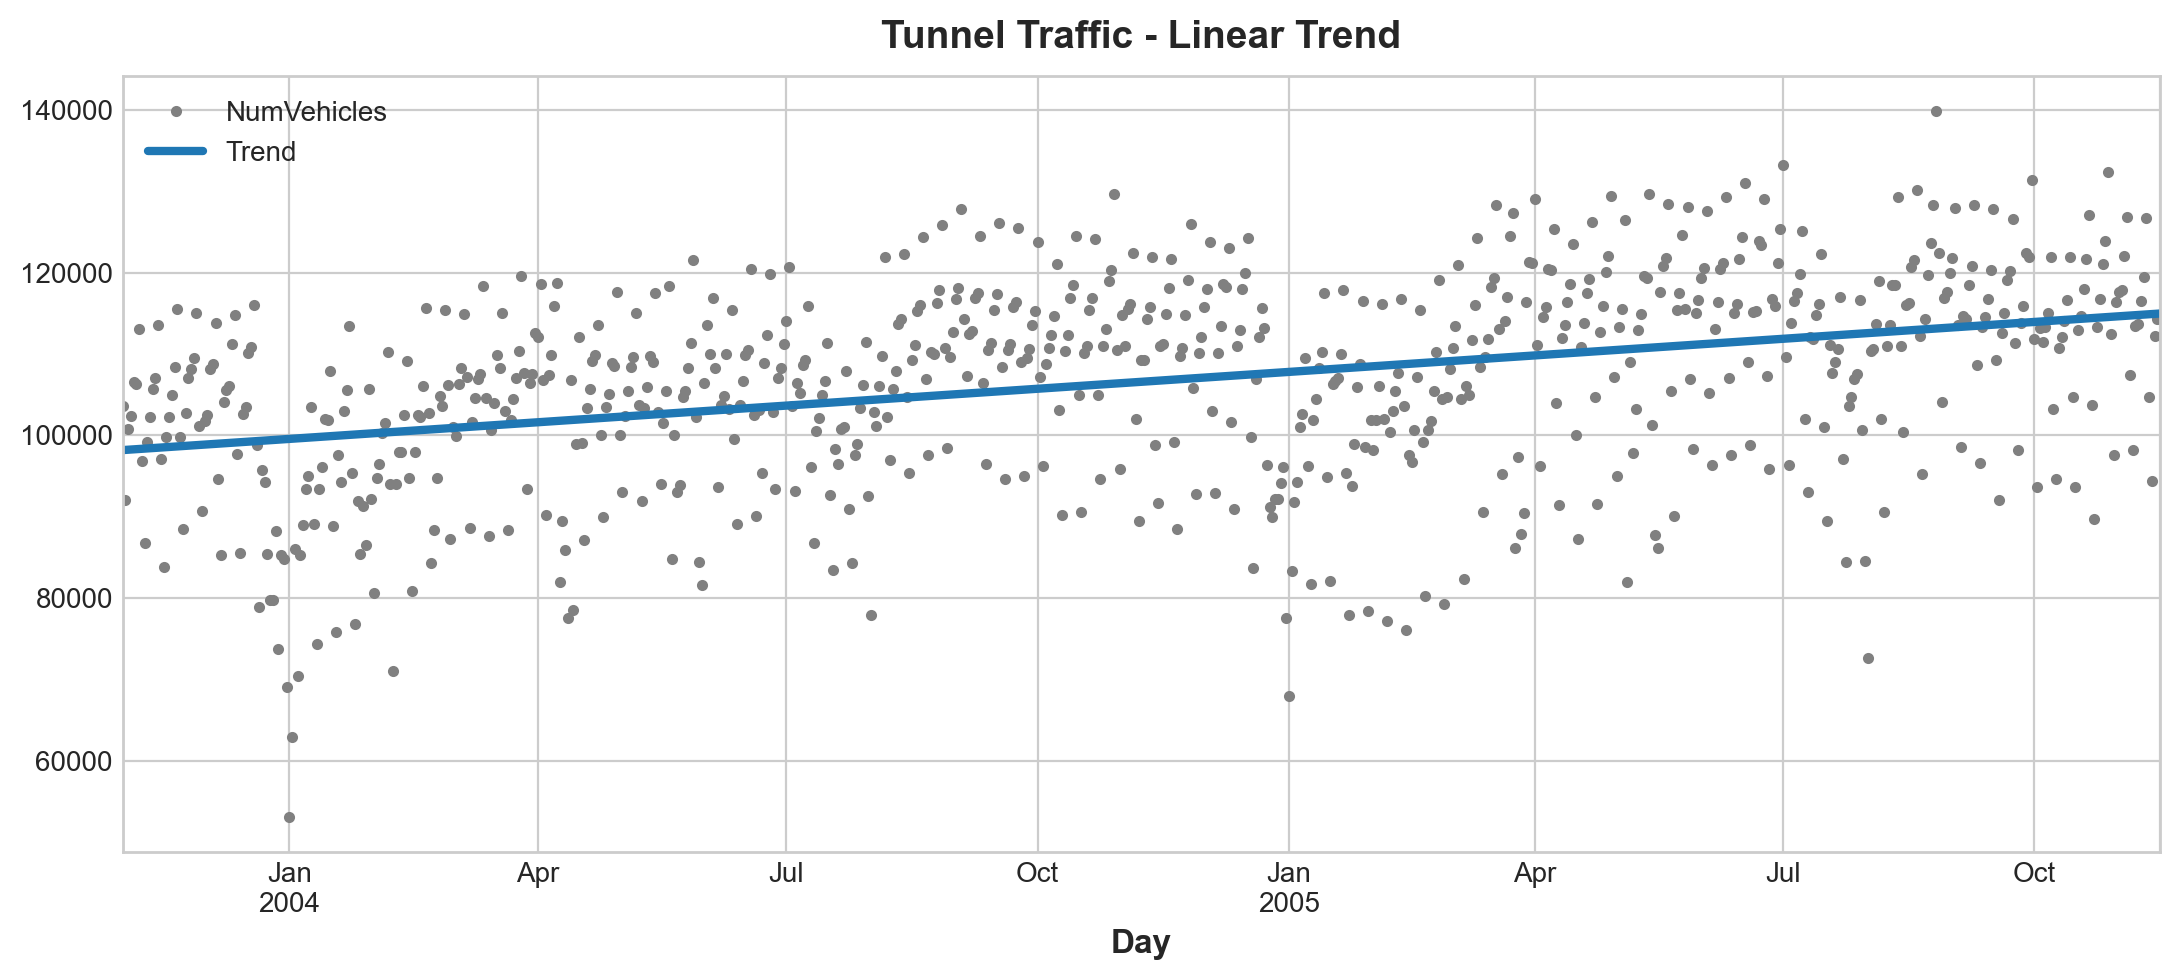

In [53]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")
_ = ax.legend()


The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.
To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [29]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

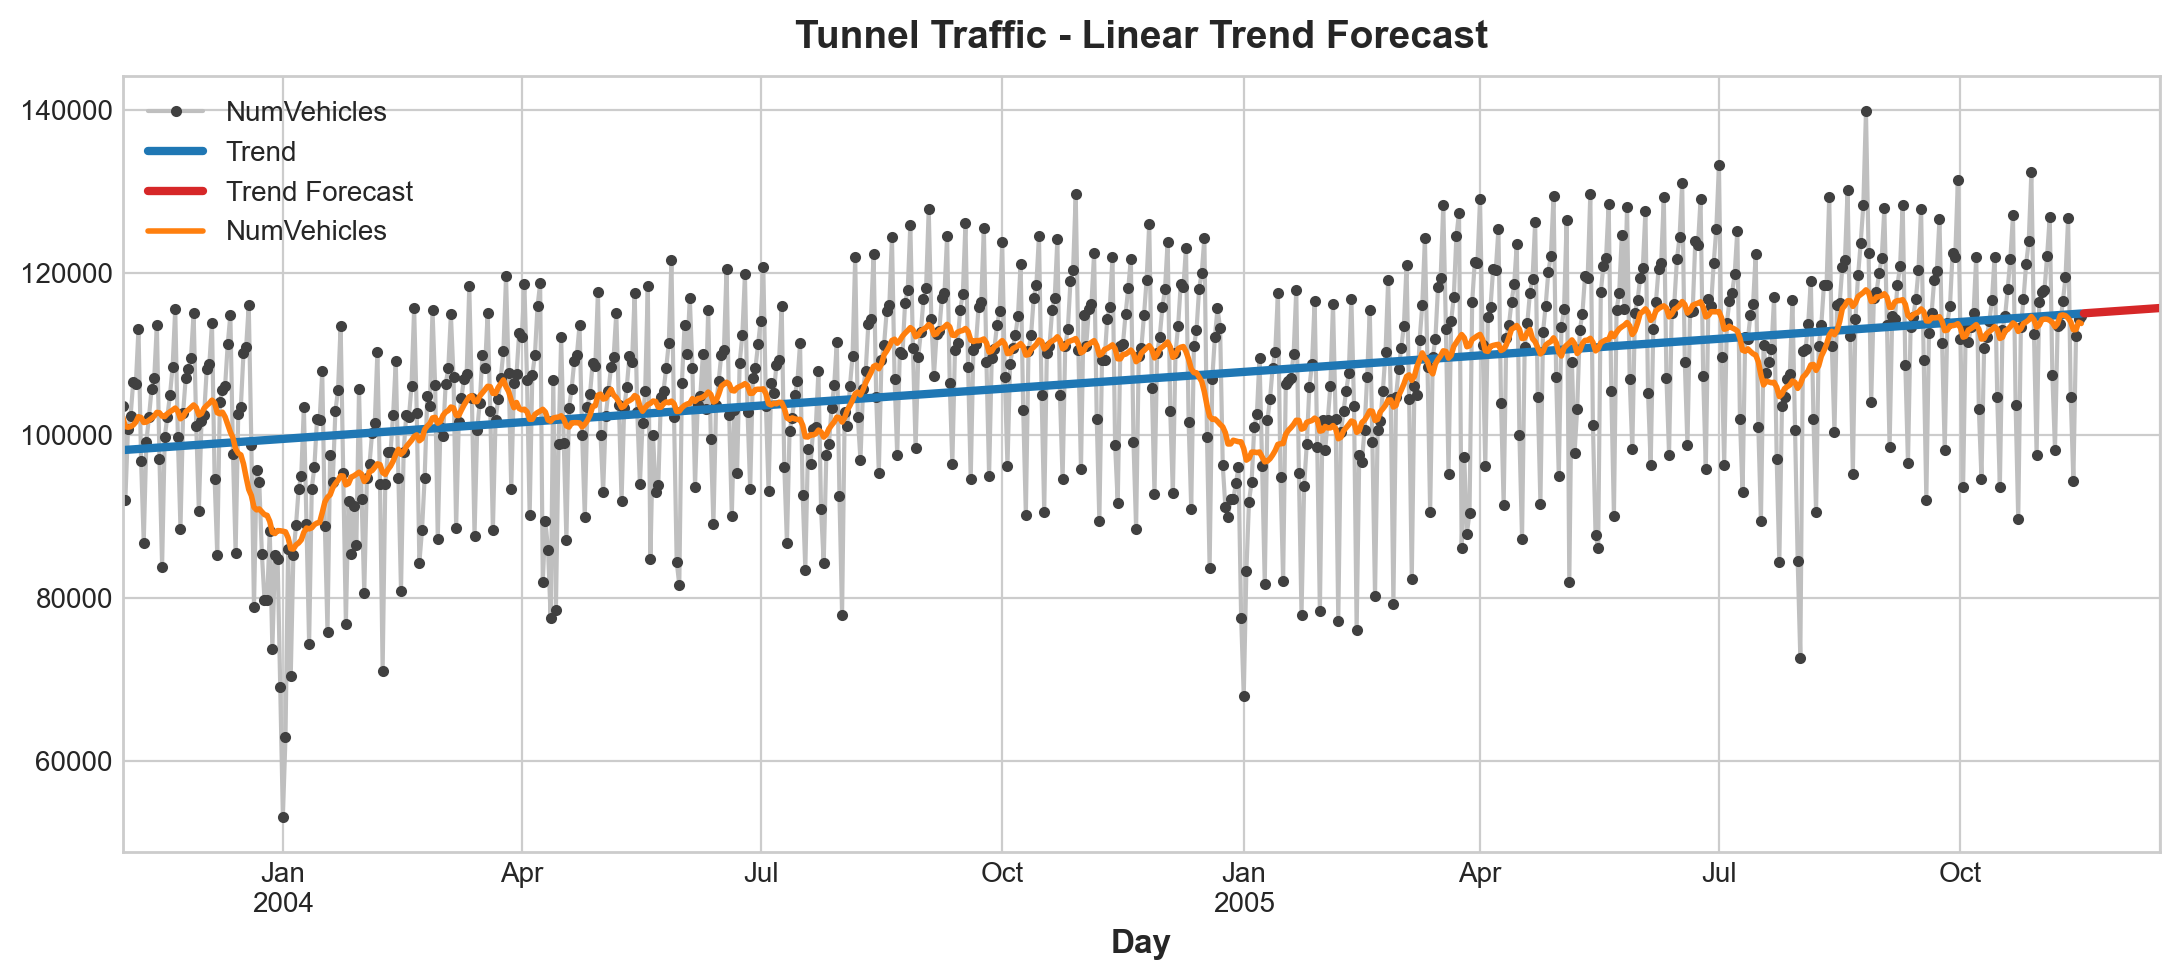

In [52]:
ax = tunnel["2003-01":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params) # Actual number of cars
ax = y_pred["2003-01":].plot(ax=ax, linewidth=3, label="Trend") # Trend
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3") # Forecast
ax = moving_average.plot(ax=ax, linewidth=2, label = 'Moving Average 30 days') # Moving average
_ = ax.legend()


### Some exercise on Trend

In [75]:
retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('M')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

### Determine trend with a moving average plot

The US Retail Sales dataset contains monthly sales data for a number of retail industries in the United States. Let's to see a plot of the Food and Beverage series.

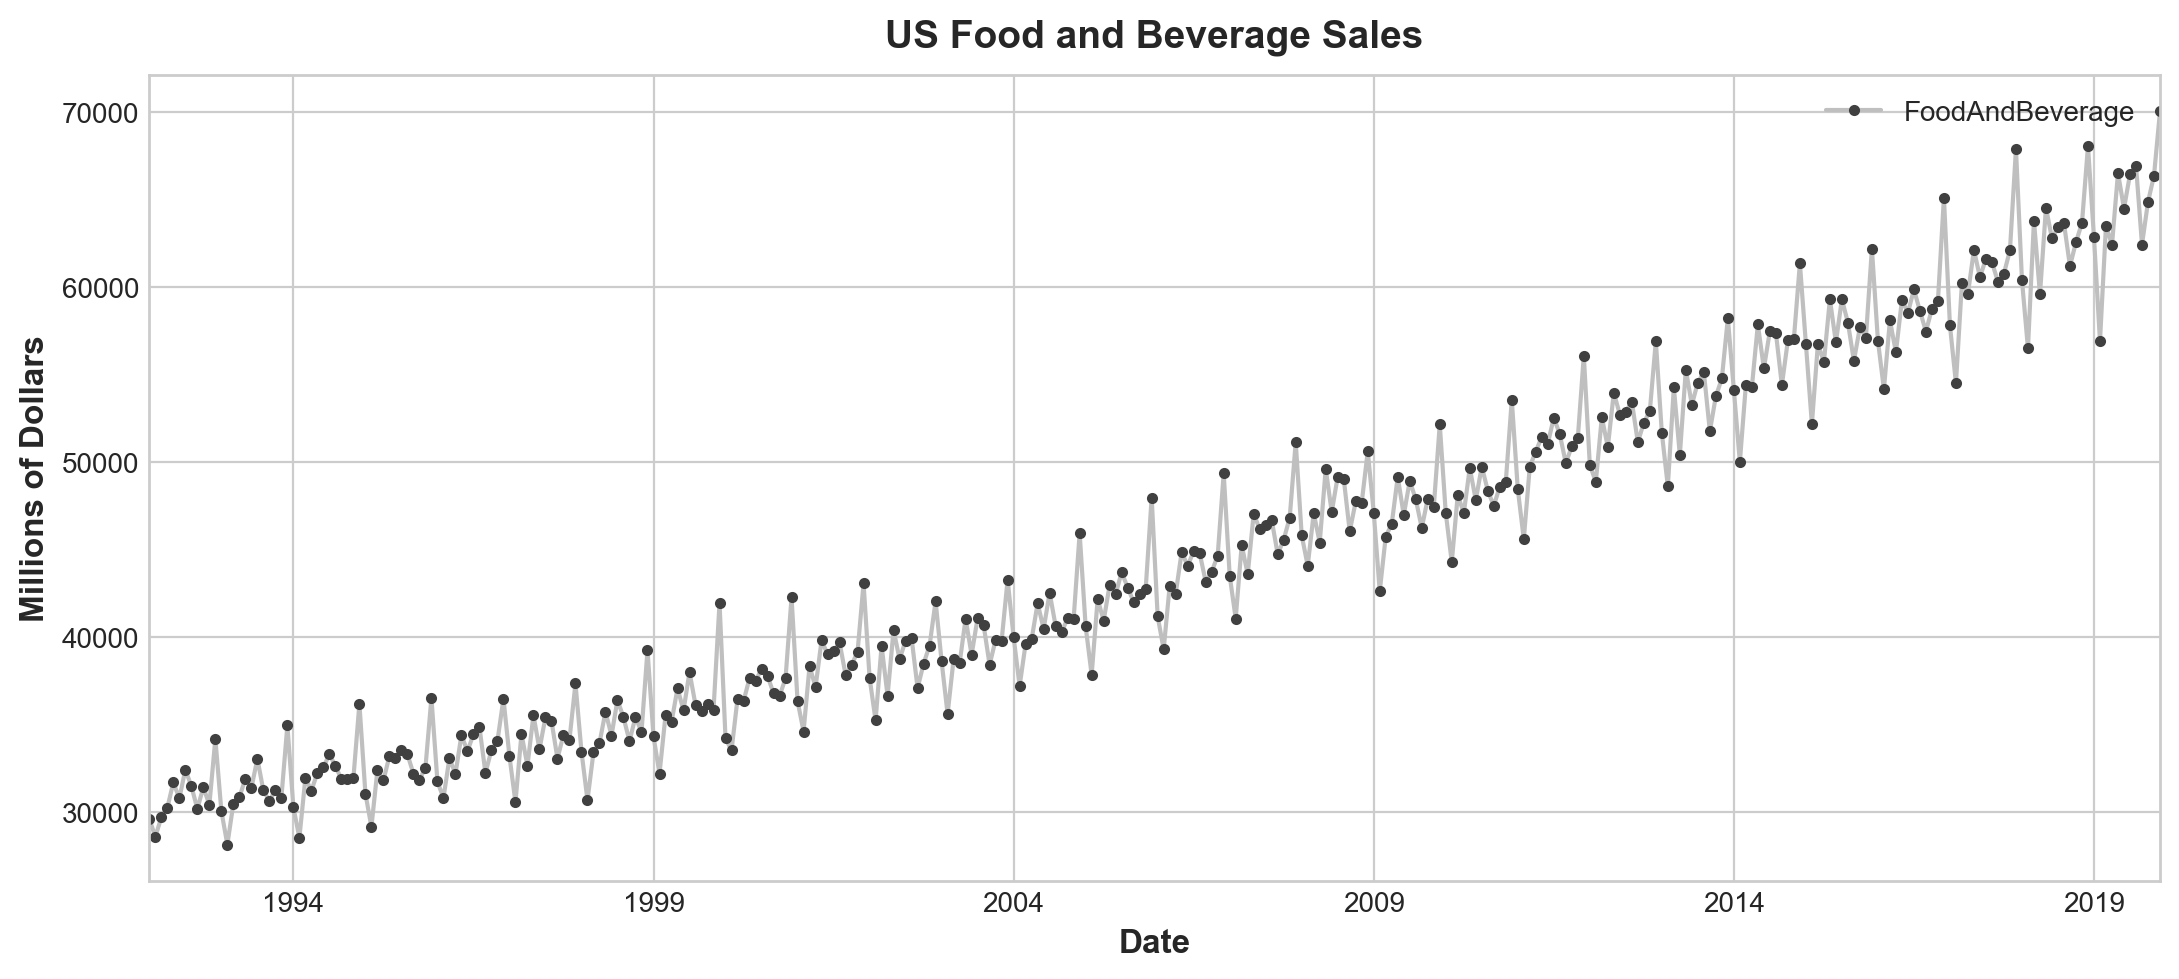

In [82]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars", xlabel="Date");

Now let's make a moving average plot to estimate the trend for this series.


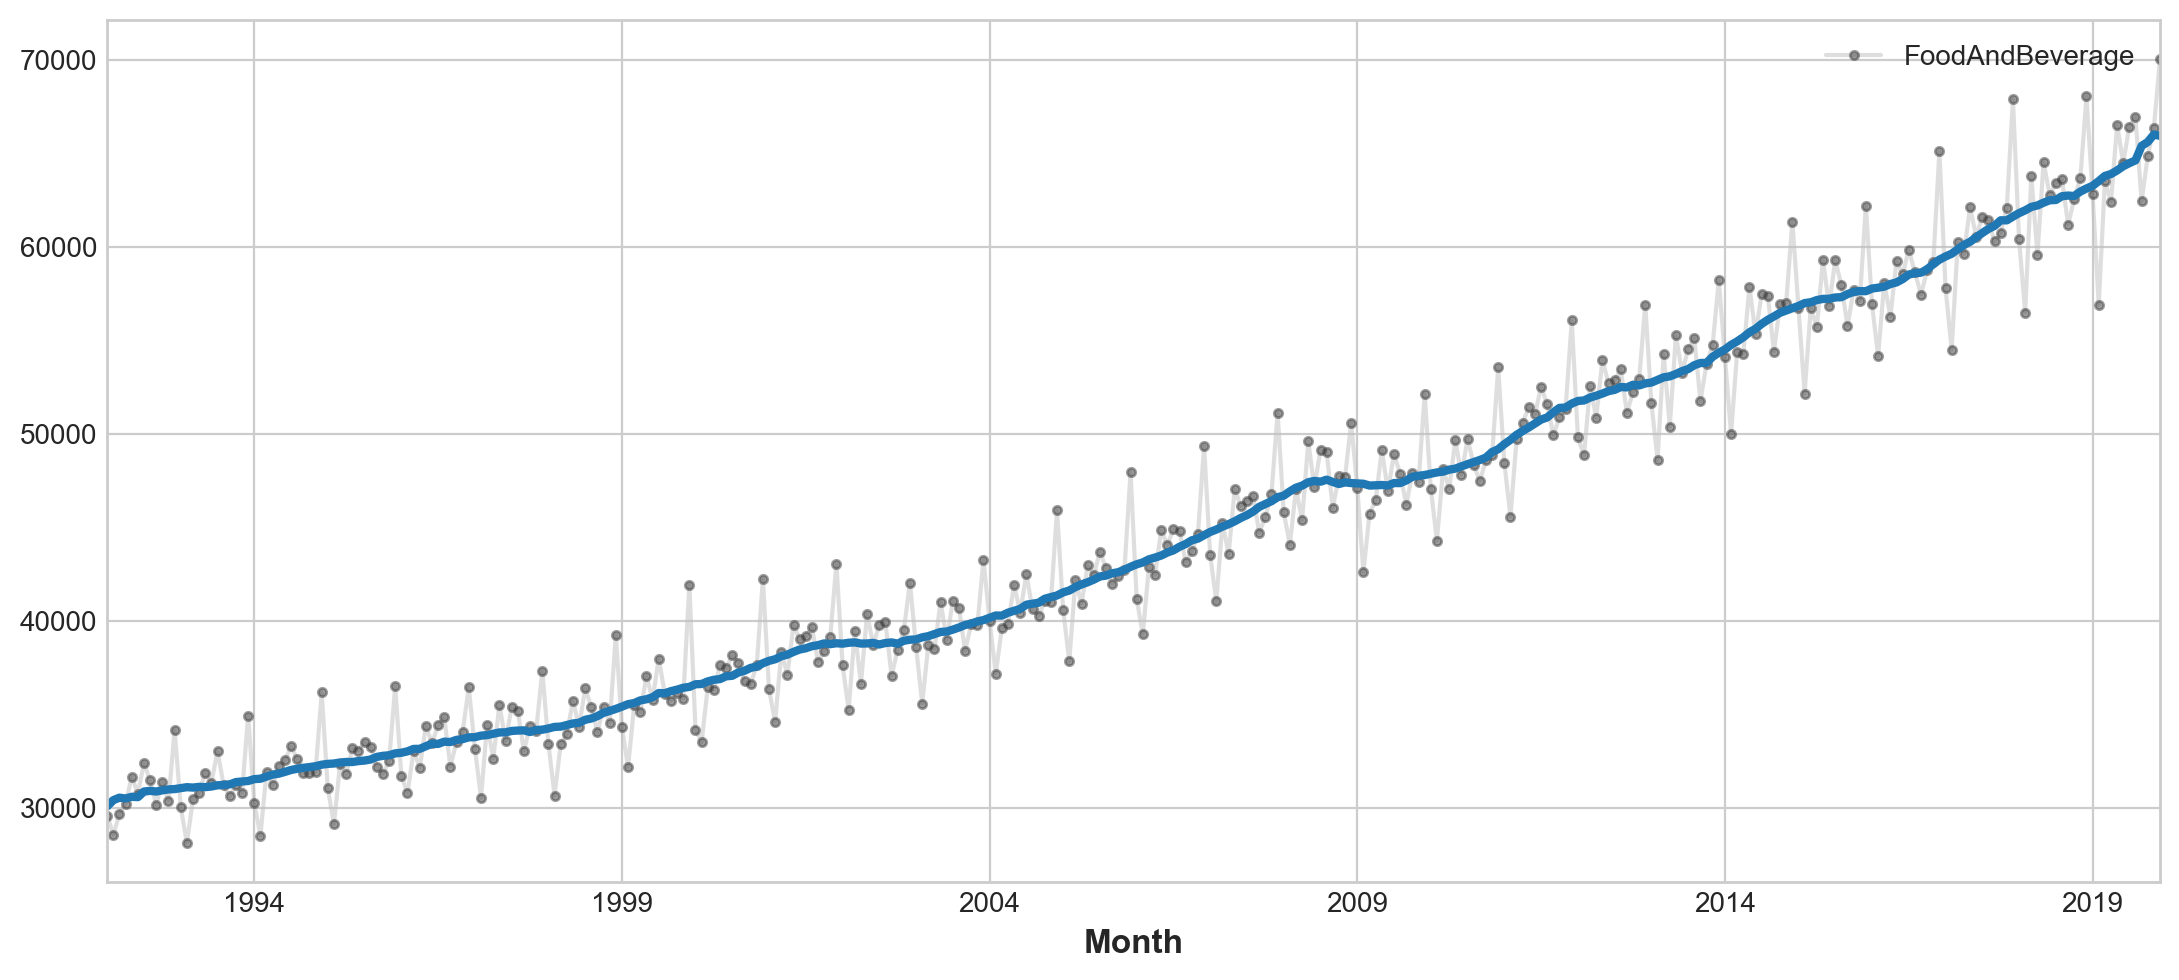

In [93]:
trend = food_sales.rolling(
    window=12,       # 12-day window
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### Let's create a Trend Feature

Let'suUse `DeterministicProces`s to create a feature set for a cubic trend model. Also we will create features for a 90-day forecast.

In [94]:
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

In [104]:
y = average_sales.copy()  # the target

# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

print('X: ', X, 'X_fore: ', X_fore)

X:              const   trend  trend_squared   trend_cubed
date                                                  
2013-01-01    1.0     1.0            1.0  1.000000e+00
2013-01-02    1.0     2.0            4.0  8.000000e+00
2013-01-03    1.0     3.0            9.0  2.700000e+01
2013-01-04    1.0     4.0           16.0  6.400000e+01
2013-01-05    1.0     5.0           25.0  1.250000e+02
...           ...     ...            ...           ...
2017-08-11    1.0  1680.0      2822400.0  4.741632e+09
2017-08-12    1.0  1681.0      2825761.0  4.750104e+09
2017-08-13    1.0  1682.0      2829124.0  4.758587e+09
2017-08-14    1.0  1683.0      2832489.0  4.767079e+09
2017-08-15    1.0  1684.0      2835856.0  4.775582e+09

[1684 rows x 4 columns] X_fore:              const   trend  trend_squared   trend_cubed
2017-08-16    1.0  1685.0      2839225.0  4.784094e+09
2017-08-17    1.0  1686.0      2842596.0  4.792617e+09
2017-08-18    1.0  1687.0      2845969.0  4.801150e+09
2017-08-19    1.0  1688.0  

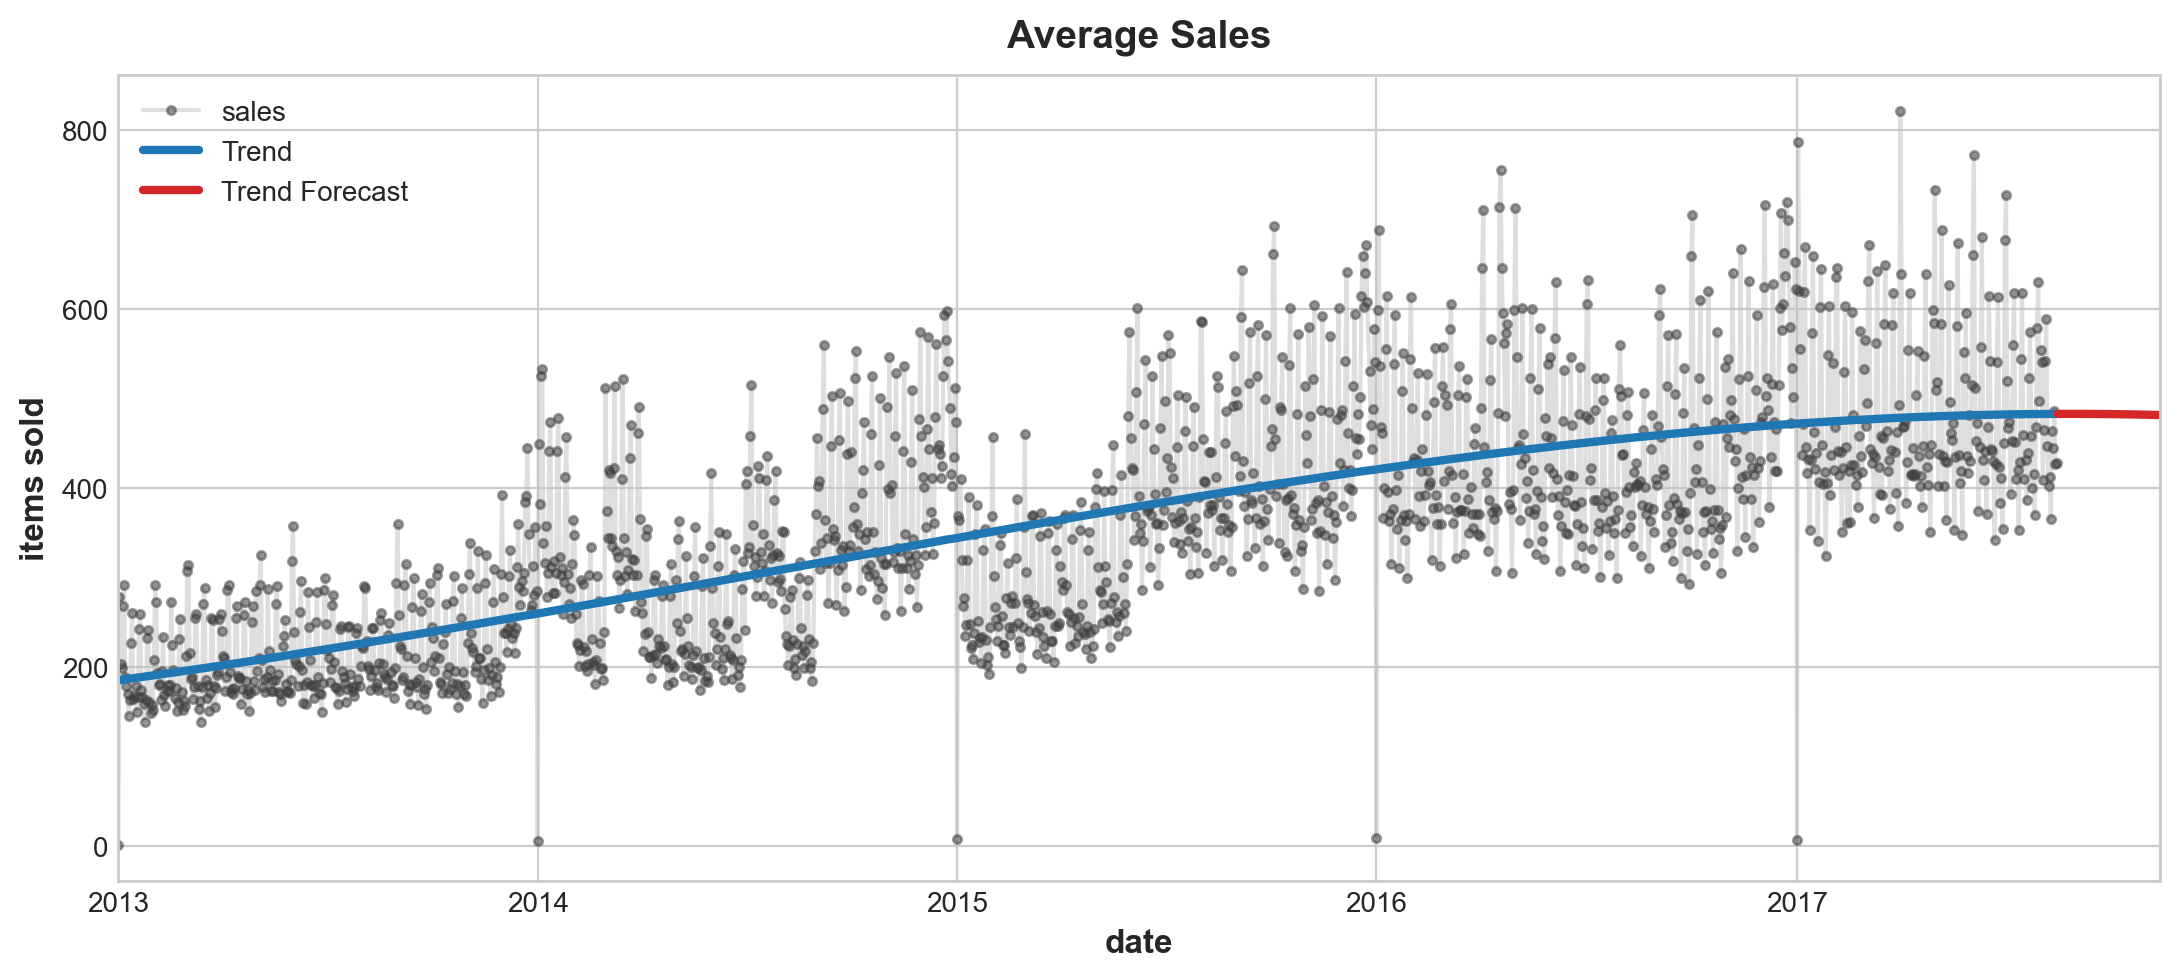

In [105]:
# Let's plot it

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();